In [1]:
#0 Importação de Bibliotecas Essenciais

"""
Importar as bibliotecas essenciais para processamento de imagem, aprendizado de máquina, e visualização.
Manter a compatibilidade com o código original.
"""

import os
import random
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms

# Configuração inicial
SEED = 1234

def set_seeds(seed=1234):
    """Garantir reprodutibilidade."""
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # Para multi-GPU

set_seeds(seed=SEED)

# Definir dispositivo de execução (GPU ou CPU)
cuda = True
device = torch.device("cuda" if (torch.cuda.is_available() and cuda) else "cpu")
print(f"Executando no dispositivo: {device}")


Executando no dispositivo: cuda


In [2]:
#1 Definir os Caminhos para os Datasets

"""
Definir os caminhos para os datasets e carregar os arquivos de imagem.
Manter a compatibilidade com o formato original.
"""

# Caminhos para os datasets
path_abnormal = "/home/thalles.fontainha/dataset/OAI-MRI-3DDESS/abnormal-3DESS-128-64.npy"
path_normal = "/home/thalles.fontainha/dataset/OAI-MRI-3DDESS/normal-3DESS-128-64.npy"

# Verificar se os arquivos existem
if not os.path.exists(path_abnormal):
    raise FileNotFoundError(f"Arquivo não encontrado: {path_abnormal}")
if not os.path.exists(path_normal):
    raise FileNotFoundError(f"Arquivo não encontrado: {path_normal}")

# Carregar os dados em arrays numpy
data_abnormal = np.load(path_abnormal)
data_normal = np.load(path_normal)

# Exibir informações básicas sobre os dados
print(f"Dados abnormal: shape={data_abnormal.shape}, tipo={data_abnormal.dtype}")
print(f"Dados normal: shape={data_normal.shape}, tipo={data_normal.dtype}")

# Exibir o número total de entradas em cada conjunto
def count_images(data, label):
    print(f"Total {label} imagens: {len(data)}")

print("-------------------Dataset------------------")
count_images(data_abnormal, "abnormal")
count_images(data_normal, "normal")


Dados abnormal: shape=(1317, 128, 128, 64), tipo=float32
Dados normal: shape=(1659, 128, 128, 64), tipo=float32
-------------------Dataset------------------
Total abnormal imagens: 1317
Total normal imagens: 1659


In [3]:
#2 Dividir os Datasets em Treino, Validação e Teste

"""
Dividir os datasets em proporções 70% treino, 15% validação, e 15% teste.
Incluir os rótulos correspondentes.
"""

def split_dataset_with_labels(data_abnormal, data_normal, train_ratio=0.7, val_ratio=0.15):
    """
    Divide os dados abnormal e normal em conjuntos de treino, validação e teste.
    Adiciona rótulos (1 para abnormal, 0 para normal) diretamente durante a divisão.
    """
    # Determinar tamanhos de cada conjunto
    train_size_abnormal = int(len(data_abnormal) * train_ratio)
    val_size_abnormal = int(len(data_abnormal) * val_ratio)
    test_size_abnormal = len(data_abnormal) - (train_size_abnormal + val_size_abnormal)

    train_size_normal = int(len(data_normal) * train_ratio)
    val_size_normal = int(len(data_normal) * val_ratio)
    test_size_normal = len(data_normal) - (train_size_normal + val_size_normal)

    # Dividir os dados e adicionar rótulos diretamente
    train_data = [(x, 1) for x in data_abnormal[:train_size_abnormal]] + \
                 [(x, 0) for x in data_normal[:train_size_normal]]
    val_data = [(x, 1) for x in data_abnormal[train_size_abnormal:train_size_abnormal + val_size_abnormal]] + \
               [(x, 0) for x in data_normal[train_size_normal:train_size_normal + val_size_normal]]
    test_data = [(x, 1) for x in data_abnormal[train_size_abnormal + val_size_abnormal:]] + \
                [(x, 0) for x in data_normal[train_size_normal + val_size_normal:]]

    # Embaralhar para evitar padrões
    random.shuffle(train_data)
    random.shuffle(val_data)
    random.shuffle(test_data)

    return train_data, val_data, test_data

# Usar a função ajustada
train_data, val_data, test_data = split_dataset_with_labels(data_abnormal, data_normal)

# Validar tamanhos dos conjuntos
print("-------------------Dataset------------------")
print(f"Total de imagens no treino: {len(train_data)}")
print(f"Total de imagens na validação: {len(val_data)}")
print(f"Total de imagens no teste: {len(test_data)}")

# Verificar presença das classes no conjunto de teste
labels_test = [label for _, label in test_data]
print(f"Número de exemplos classe 0 (normal): {labels_test.count(0)}")
print(f"Número de exemplos classe 1 (abnormal): {labels_test.count(1)}")


-------------------Dataset------------------
Total de imagens no treino: 2082
Total de imagens na validação: 445
Total de imagens no teste: 449
Número de exemplos classe 0 (normal): 250
Número de exemplos classe 1 (abnormal): 199


In [5]:
#3 Analisar os Modelos Disponíveis no Dicionário

"""
Criar uma função para inspecionar e listar os modelos disponíveis no dicionário, 
verificando se estão corretamente configurados e exibindo informações relevantes.
"""

# Dicionário de modelos
model_dict = {
    "densenet121": lambda: models.densenet121(weights=models.DenseNet121_Weights.IMAGENET1K_V1),
    "resnet50": lambda: models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1),
    "efficientnet_b0": lambda: models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1),
    "mobilenet_v2": lambda: models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V1),
    "vgg16": lambda: models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1),
}

def analyze_model_dict(model_dict):
    """
    Exibe os nomes dos modelos disponíveis no dicionário, valida cada instância e mostra detalhes básicos.
    """
    print("-------------------Modelos Disponíveis------------------")
    for model_name, model_fn in model_dict.items():
        try:
            # Carregar modelo
            model_instance = model_fn()
            
            # Exibir informações do modelo
            print(f"\nModelo '{model_name}':")
            print(f" - Arquitetura: {type(model_instance).__name__}")
            print(f" - Número total de parâmetros: {sum(p.numel() for p in model_instance.parameters())}")
            print(f" - Número de camadas treináveis: {sum(p.requires_grad for p in model_instance.parameters())}")
        except Exception as e:
            print(f"Erro ao carregar o modelo '{model_name}': {e}")

# Aplicar a análise
analyze_model_dict(model_dict)



-------------------Modelos Disponíveis------------------

Modelo 'densenet121':
 - Arquitetura: DenseNet
 - Número total de parâmetros: 7978856
 - Número de camadas treináveis: 364

Modelo 'resnet50':
 - Arquitetura: ResNet
 - Número total de parâmetros: 25557032
 - Número de camadas treináveis: 161

Modelo 'efficientnet_b0':
 - Arquitetura: EfficientNet
 - Número total de parâmetros: 5288548
 - Número de camadas treináveis: 213

Modelo 'mobilenet_v2':
 - Arquitetura: MobileNetV2
 - Número total de parâmetros: 3504872
 - Número de camadas treináveis: 158

Modelo 'vgg16':
 - Arquitetura: VGG
 - Número total de parâmetros: 138357544
 - Número de camadas treináveis: 32


In [6]:
#4 Verificar distribuição de classes no conjunto de teste
def analyze_class_distribution(test_data):
    """
    Analisa e exibe a distribuição de classes no conjunto de teste.
    """
    labels_test = [label for _, label in test_data]  # Extrair rótulos
    num_normal = labels_test.count(0)
    num_abnormal = labels_test.count(1)

    print("-------------------Distribuição de Classes------------------")
    print(f"Número de exemplos classe 0 (normal): {num_normal}")
    print(f"Número de exemplos classe 1 (abnormal): {num_abnormal}")

# Aplicar a análise da distribuição de classes
analyze_class_distribution(test_data)

-------------------Distribuição de Classes------------------
Número de exemplos classe 0 (normal): 250
Número de exemplos classe 1 (abnormal): 199


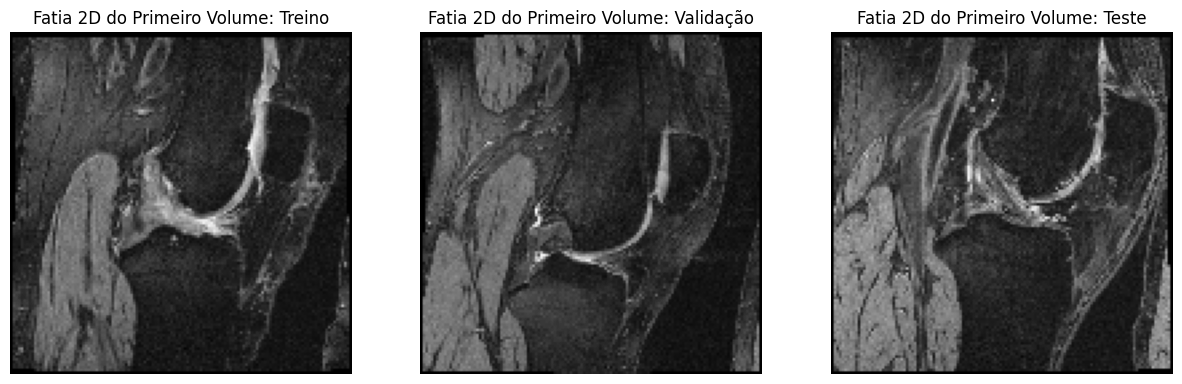

In [7]:
#5 Exibir três imagens: uma de treino, uma de validação, uma de teste
def visualize_images(train_data, val_data, test_data):
    """
    Visualiza uma fatia central de um volume de treino, validação e teste.
    """
    # Selecionar uma fatia central de cada conjunto
    train_image = train_data[0][0][:, :, train_data[0][0].shape[2] // 2]  # Fatia central do primeiro volume
    val_image = val_data[0][0][:, :, val_data[0][0].shape[2] // 2]        # Fatia central do primeiro volume
    test_image = test_data[0][0][:, :, test_data[0][0].shape[2] // 2]     # Fatia central do primeiro volume

    # Normalizar os valores para 0-255
    def normalize_image(image):
        image = (image - image.min()) / (image.max() - image.min())  # Normalizar para [0, 1]
        return (image * 255).astype(np.uint8)  # Escalar para [0, 255]

    train_image = normalize_image(train_image)
    val_image = normalize_image(val_image)
    test_image = normalize_image(test_image)

    # Criar o plot
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(train_image, cmap='gray')
    plt.title('Fatia 2D do Primeiro Volume: Treino')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(val_image, cmap='gray')
    plt.title('Fatia 2D do Primeiro Volume: Validação')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(test_image, cmap='gray')
    plt.title('Fatia 2D do Primeiro Volume: Teste')
    plt.axis('off')

    plt.show()

# Visualizar as imagens
visualize_images(train_data, val_data, test_data)

In [8]:
#6 Definir as Transformações para os Datasets

"""
Definir transformações para pré-processamento dos dados. 
Inclui augmentações no conjunto de treino e normalização para todos os conjuntos.
"""

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomRotation(degrees=15),  # Rotação aleatória
        transforms.RandomHorizontalFlip(),     # Flip horizontal aleatório
        transforms.ToTensor(),                 # Converter para tensor
        transforms.Normalize([0.5], [0.5])     # Normalização para escala de cinza (1 canal)
    ]),
    'others': transforms.Compose([
        transforms.ToTensor(),                 # Converter para tensor
        transforms.Normalize([0.5], [0.5])     # Normalização para escala de cinza (1 canal)
    ]),
}

In [9]:
#7 Definir a Classe Customizada para o Dataset

"""
Criar uma classe para lidar com os dados e rótulos, além de aplicar transformações.
"""

from torch.utils.data import Dataset

class OAI_MRI_Dataset(Dataset):
    def __init__(self, data, transform=None):
        """
        Inicializa o dataset com os dados e rótulos.
        """
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        """
        Retorna uma imagem e seu rótulo correspondente.
        """
        # Obter volume e rótulo
        volume, label = self.data[idx]

        # Selecionar uma fatia central
        slice_index = volume.shape[2] // 2
        image_data = volume[:, :, slice_index]

        # Normalizar os valores
        image_data = (image_data - image_data.min()) / (image_data.max() - image_data.min())
        image_data = (image_data * 255).astype(np.uint8)

        # Converter para imagem PIL
        image = Image.fromarray(image_data)

        # Aplicar transformações (se houver)
        if self.transform:
            image = self.transform(image)

        return image, label

# Criar datasets para treino, validação e teste
train_dataset = OAI_MRI_Dataset(train_data, transform=data_transforms['train'])
val_dataset = OAI_MRI_Dataset(val_data, transform=data_transforms['others'])
test_dataset = OAI_MRI_Dataset(test_data, transform=data_transforms['others'])

# Criar DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Verificar os tamanhos dos DataLoaders
print("-------------------DataLoaders------------------")
print(f"Tamanho do DataLoader de treino: {len(train_dataloader)} batches")
print(f"Tamanho do DataLoader de validação: {len(val_dataloader)} batches")
print(f"Tamanho do DataLoader de teste: {len(test_dataloader)} batches")

-------------------DataLoaders------------------
Tamanho do DataLoader de treino: 66 batches
Tamanho do DataLoader de validação: 14 batches
Tamanho do DataLoader de teste: 15 batches


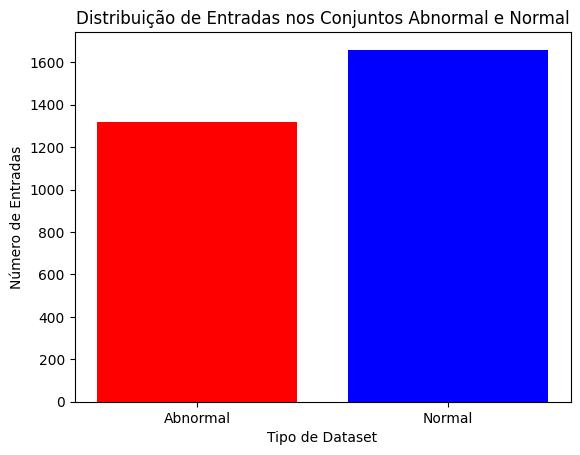

In [10]:
#8 Visualizar Distribuição de Dados

"""
Gerar um gráfico de barras para visualizar a distribuição inicial 
dos dados abnormal e normal no dataset completo.
"""

abnormal_size = len(data_abnormal)
normal_size = len(data_normal)
sizes = [abnormal_size, normal_size]

# Criar o gráfico de barras
plt.bar(['Abnormal', 'Normal'], sizes, color=['red', 'blue'])
plt.xlabel('Tipo de Dataset')
plt.ylabel('Número de Entradas')
plt.title('Distribuição de Entradas nos Conjuntos Abnormal e Normal')
plt.show()

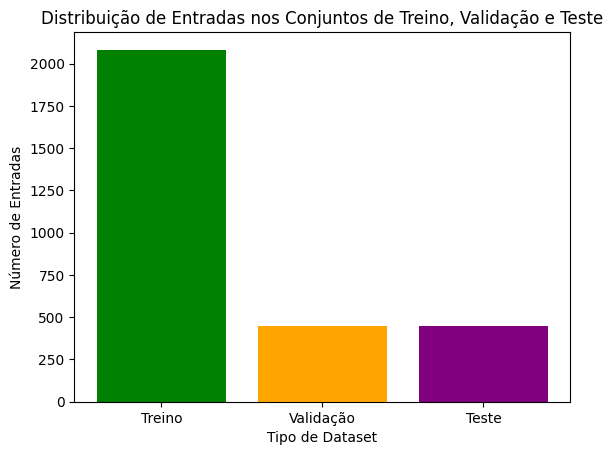

In [11]:
#9 Visualizar Distribuição dos Datasets de Treino, Validação e Teste

"""
Gerar um gráfico de barras para visualizar a distribuição dos 
datasets de treino, validação e teste.
"""

train_size = len(train_data)
valid_size = len(val_data)
test_size = len(test_data)

# Criar lista com os tamanhos
sizes = [train_size, valid_size, test_size]

# Criar o gráfico de barras
plt.bar(['Treino', 'Validação', 'Teste'], sizes, color=['green', 'orange', 'purple'])
plt.xlabel('Tipo de Dataset')
plt.ylabel('Número de Entradas')
plt.title('Distribuição de Entradas nos Conjuntos de Treino, Validação e Teste')
plt.show()

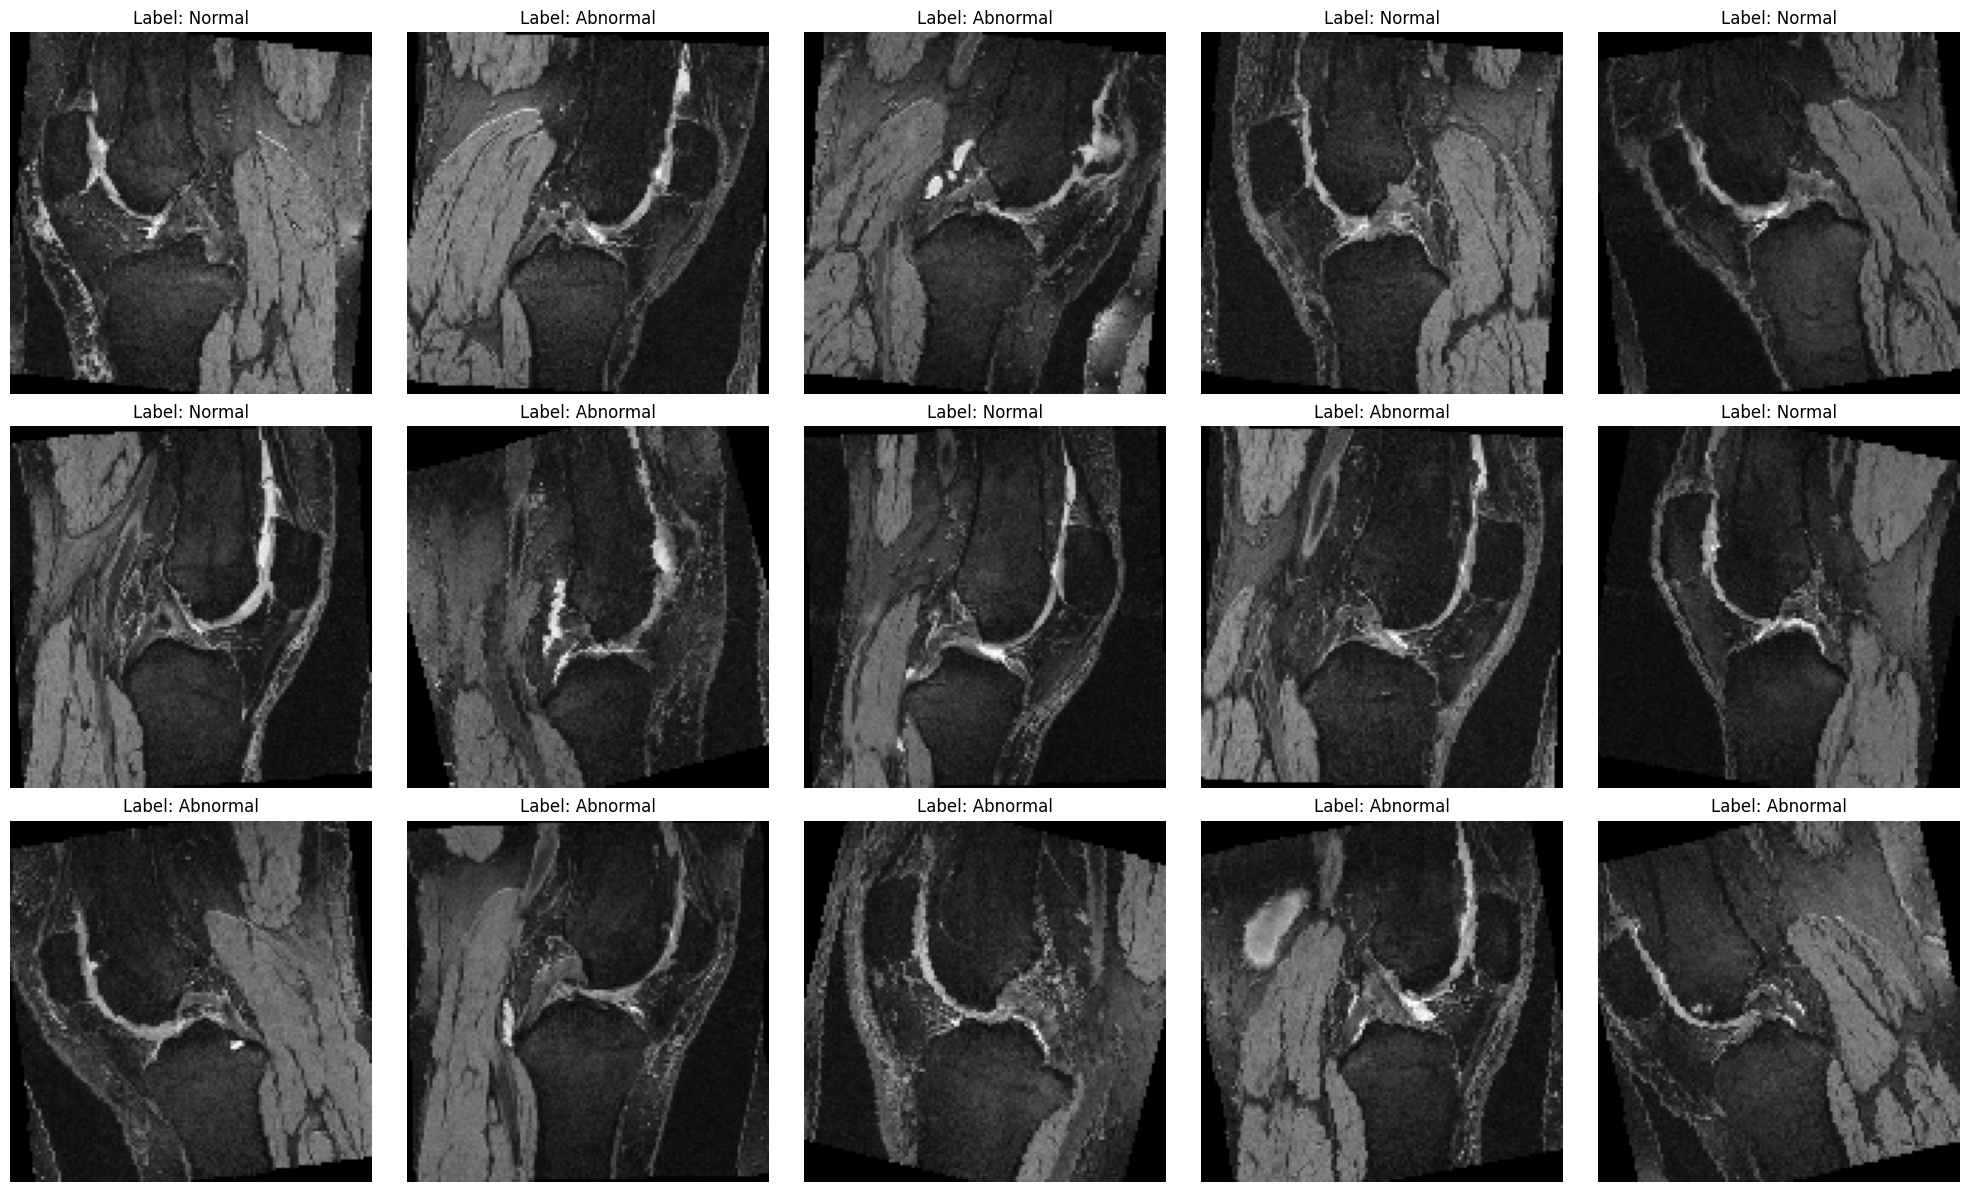

In [12]:
#10 Visualizar Algumas Imagens do DataLoader

"""
Visualizar um batch de imagens do DataLoader de treino, mostrando as respectivas labels.
"""

# Carregar um batch de dados
data, labels = next(iter(train_dataloader))

# Criar figura com uma grade de subplots
fig, axs = plt.subplots(nrows=3, ncols=5, figsize=(20, 12))

# Plotar as imagens nos subplots
for i, ax in enumerate(axs.flat):
    if i >= len(data):
        break

    # Obter a imagem e o label
    image, label = data[i], labels[i]

    # Converter a imagem para numpy array
    img = image.numpy().squeeze()  # Remove dimensões extras (para imagens em escala de cinza)
    img = (img - img.min()) / (img.max() - img.min())  # Normalizar para [0, 1]

    # Mostrar a imagem
    ax.imshow(img, cmap='gray')
    ax.set_title(f'Label: {"Abnormal" if label.item() == 1 else "Normal"}')
    ax.axis('off')

# Mostrar o gráfico
plt.tight_layout()
plt.show()


In [13]:
#11 Definir Modelos Personalizados Baseados nos 6 Modelos Selecionados

import torch.nn as nn
from torchvision import models

class CustomDenseNetModel(nn.Module):
    """Modelo DenseNet121 pretreinado adaptado."""
    def __init__(self, num_classes):
        super(CustomDenseNetModel, self).__init__()

        # Carregar o modelo DenseNet121 com pesos pretreinados
        self.model = models.densenet121(weights=models.DenseNet121_Weights.IMAGENET1K_V1)

        # Congelar os parâmetros do modelo base
        for param in self.model.features.parameters():
            param.requires_grad = False

        # Substituir a camada classificador
        in_features = self.model.classifier.in_features
        self.model.classifier = nn.Sequential(
            nn.Linear(in_features, in_features // 2),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(in_features // 2, in_features // 4),
            nn.ReLU(),
            nn.Linear(in_features // 4, num_classes),
        )

    def forward(self, x):
        return self.model(x)


class CustomResNet50Model(nn.Module):
    """Modelo ResNet50 pretreinado adaptado."""
    def __init__(self, num_classes):
        super(CustomResNet50Model, self).__init__()

        # Carregar o modelo ResNet50 com pesos pretreinados
        self.model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)

        # Congelar os parâmetros do modelo base
        for param in self.model.parameters():
            param.requires_grad = False

        # Substituir a camada classificador
        in_features = self.model.fc.in_features
        self.model.fc = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.model(x)


class CustomEfficientNetModel(nn.Module):
    """Modelo EfficientNet_B0 pretreinado adaptado."""
    def __init__(self, num_classes):
        super(CustomEfficientNetModel, self).__init__()

        # Carregar o modelo EfficientNet_B0 com pesos pretreinados
        self.model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)

        # Congelar os parâmetros do modelo base
        for param in self.model.features.parameters():
            param.requires_grad = False

        # Substituir a camada classificador
        in_features = self.model.classifier[1].in_features
        self.model.classifier = nn.Sequential(
            nn.Linear(in_features, in_features // 2),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(in_features // 2, num_classes)
        )

    def forward(self, x):
        return self.model(x)


class CustomMobileNetV2Model(nn.Module):
    """Modelo MobileNetV2 pretreinado adaptado."""
    def __init__(self, num_classes):
        super(CustomMobileNetV2Model, self).__init__()

        # Carregar o modelo MobileNetV2 com pesos pretreinados
        self.model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V1)

        # Congelar os parâmetros do modelo base
        for param in self.model.features.parameters():
            param.requires_grad = False

        # Substituir a camada classificador
        in_features = self.model.classifier[1].in_features
        self.model.classifier = nn.Sequential(
            nn.Linear(in_features, in_features // 2),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(in_features // 2, num_classes)
        )

    def forward(self, x):
        return self.model(x)


class CustomVGG16Model(nn.Module):
    """Modelo VGG16 pretreinado adaptado."""
    def __init__(self, num_classes):
        super(CustomVGG16Model, self).__init__()

        # Carregar o modelo VGG16 com pesos pretreinados
        self.model = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)

        # Congelar os parâmetros do modelo base
        for param in self.model.features.parameters():
            param.requires_grad = False

        # Substituir a camada classificador
        in_features = self.model.classifier[6].in_features
        self.model.classifier[6] = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.model(x)

# Instanciar os 6 modelos
models_list = {
    "DenseNet121": CustomDenseNetModel(num_classes=2),
    "ResNet50": CustomResNet50Model(num_classes=2),
    "EfficientNet_B0": CustomEfficientNetModel(num_classes=2),
    "MobileNetV2": CustomMobileNetV2Model(num_classes=2),
    "VGG16": CustomVGG16Model(num_classes=2),
}

# Definir o dispositivo (CPU ou GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Transferir modelos para o dispositivo e exibir arquiteturas
for model_name, model_instance in models_list.items():
    model_instance = model_instance.to(device)
    print(f"\nModelo: {model_name}")
    print(model_instance)



Modelo: DenseNet121
CustomDenseNetModel(
  (model): DenseNet(
    (features): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNor

In [14]:
#12 Calcular os Pesos para Cada Classe no Conjunto de Treino

"""
Calcular os pesos das classes com base na distribuição de exemplos no conjunto de treino.
"""

# Contar os exemplos de cada classe no conjunto de treino
def calculate_class_distribution(dataloader):
    """Calcula a distribuição das classes em um DataLoader."""
    abnormal_count = 0
    normal_count = 0
    for _, labels in dataloader:
        abnormal_count += torch.sum(labels == 1).item()  # Classe Abnormal (rótulo 1)
        normal_count += torch.sum(labels == 0).item()    # Classe Normal (rótulo 0)
    return abnormal_count, normal_count

# Obter a contagem das classes no conjunto de treino
abnormal_count, normal_count = calculate_class_distribution(train_dataloader)

# Calcular o total de exemplos
total = abnormal_count + normal_count

# Função para calcular pesos
def class_weight(count, total):
    return 1 - (count / total)

# Calcular os pesos para cada classe
class_weights = torch.tensor([
    class_weight(normal_count, total),  # Peso para a classe Normal (rótulo 0)
    class_weight(abnormal_count, total)  # Peso para a classe Abnormal (rótulo 1)
], dtype=torch.float32).to(device)  # Passar os pesos para o mesmo dispositivo do modelo

# Exibir os pesos calculados
print(f"Pesos das classes calculados:")
print(f" - Classe Normal (0): {class_weights[0]:.4f}")
print(f" - Classe Abnormal (1): {class_weights[1]:.4f}")

Pesos das classes calculados:
 - Classe Normal (0): 0.4424
 - Classe Abnormal (1): 0.5576


In [18]:
#13 Configurar Função de Perda, Otimizador e Scheduler para os 6 Modelos com Parâmetros Específicos

"""
Configurar a função de perda, otimizador e scheduler para os 6 modelos, 
com exibição de informações reduzida.
"""

# Exibir informações gerais comuns
print("-------------------Configurações Gerais------------------")
print(f"Função de Perda: BCEWithLogitsLoss")
print(f" - Peso Classe Normal (0): {class_weights[0]:.4f}")
print(f" - Peso Classe Abnormal (1): {class_weights[1]:.4f}")

# Dicionário para armazenar as configurações de cada modelo
configurations = {}

for model_name, model_instance in models_list.items():
    # Enviar o modelo para o dispositivo (GPU/CPU)
    model_instance = model_instance.to(device)

    # Definir parâmetros específicos para cada modelo
    if model_name == "DenseNet121":
        lr = 0.001
        gamma = 0.1
    elif model_name == "ResNet50":
        lr = 0.0005
        gamma = 0.15
    elif model_name == "EfficientNet_B0":
        lr = 0.001
        gamma = 0.2
    elif model_name == "MobileNetV2":
        lr = 0.0008
        gamma = 0.12
    elif model_name == "VGG16":
        lr = 0.0012
        gamma = 0.1
    else:
        lr = 0.001  # Default
        gamma = 0.1

    # Função de perda: BCEWithLogitsLoss com pesos para as classes
    loss_fn = nn.BCEWithLogitsLoss(pos_weight=class_weights[1])  # Peso da classe Abnormal

    # Otimizador: Adam
    optimizer = torch.optim.Adam(model_instance.parameters(), lr=lr)

    # Scheduler: StepLR (decaimento da taxa de aprendizado)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=gamma)

    # Salvar configurações no dicionário
    configurations[model_name] = {
        "model": model_instance,
        "loss_fn": loss_fn,
        "optimizer": optimizer,
        "scheduler": scheduler,
    }

    # Exibir configurações específicas para o modelo
    print(f"\nConfigurações específicas para o modelo: {model_name}")
    print(f" - Taxa de aprendizado inicial: {lr}")
    print(f" - Scheduler: StepLR com gamma={gamma:.2f}")


-------------------Configurações Gerais------------------
Função de Perda: BCEWithLogitsLoss
 - Peso Classe Normal (0): 0.4424
 - Peso Classe Abnormal (1): 0.5576

Configurações específicas para o modelo: DenseNet121
 - Taxa de aprendizado inicial: 0.001
 - Scheduler: StepLR com gamma=0.10

Configurações específicas para o modelo: ResNet50
 - Taxa de aprendizado inicial: 0.0005
 - Scheduler: StepLR com gamma=0.15

Configurações específicas para o modelo: EfficientNet_B0
 - Taxa de aprendizado inicial: 0.001
 - Scheduler: StepLR com gamma=0.20

Configurações específicas para o modelo: MobileNetV2
 - Taxa de aprendizado inicial: 0.0008
 - Scheduler: StepLR com gamma=0.12

Configurações específicas para o modelo: VGG16
 - Taxa de aprendizado inicial: 0.0012
 - Scheduler: StepLR com gamma=0.10


In [19]:
#14 Criar DataLoaders para Treino, Validação e Teste

"""
Configurar DataLoaders para carregar os dados em batches com embaralhamento
para treino e validação, e sem embaralhamento para teste.
"""

# Configuração do tamanho do batch
batch_size = 32  # Tamanho do batch

# Criar DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Exibir informações sobre os DataLoaders
print("-------------------DataLoaders Configurados------------------")
print(f"Total de batches no treino: {len(train_dataloader)}")
print(f"Total de batches na validação: {len(valid_dataloader)}")
print(f"Total de batches no teste: {len(test_dataloader)}")


-------------------DataLoaders Configurados------------------
Total de batches no treino: 66
Total de batches na validação: 14
Total de batches no teste: 15


In [20]:
#15 Definir a Função de Treinamento e Validação

"""
Função de treinamento e validação aplicada a múltiplos modelos,
com barras de progresso reduzidas e prints organizados.
"""

from tqdm import tqdm
import torch.nn.functional as F

# Inicializar listas para armazenar resultados
results = {}

def train_and_validate(models_config, num_epochs=25):
    """
    Função de treinamento e validação para múltiplos modelos.
    
    Args:
        models_config (dict): Dicionário contendo os modelos e suas configurações.
        num_epochs (int): Número de épocas para o treinamento.
    """
    for model_name, config in models_config.items():
        print(f"\nTreinamento do modelo: {model_name}")
        
        # Obter o modelo e suas configurações
        model = config["model"]
        loss_fn = config["loss_fn"]
        optimizer = config["optimizer"]
        scheduler = config["scheduler"]

        # Inicializar estatísticas
        train_losses = []
        valid_losses = []
        train_acc = []
        valid_acc = []

        # Treinamento por épocas
        for epoch in tqdm(range(num_epochs), desc=f"{model_name} - Épocas", leave=False):
            # Etapa de treinamento
            model.train()
            train_size, train_loss, train_accuracy = 0, 0.0, 0.0

            for images, labels in train_dataloader:
                images, labels = images.to(device), labels.to(device)

                # Ajustar canais para modelos como DenseNet e ResNet
                if images.shape[1] == 1:  # Escala de cinza
                    images = images.repeat(1, 3, 1, 1)

                optimizer.zero_grad()
                outputs = model(images)
                loss = loss_fn(outputs, F.one_hot(labels, 2).float())
                _, preds = torch.max(outputs, 1)

                # Atualizar estatísticas
                train_loss += loss.item() * images.size(0)
                train_accuracy += torch.sum(preds == labels.data).item()
                train_size += images.size(0)

                # Backpropagation e otimização
                loss.backward()
                optimizer.step()

            # Etapa de validação
            model.eval()
            valid_size, valid_loss, valid_accuracy = 0, 0.0, 0.0

            with torch.no_grad():
                for images, labels in valid_dataloader:
                    images, labels = images.to(device), labels.to(device)

                    if images.shape[1] == 1:
                        images = images.repeat(1, 3, 1, 1)

                    outputs = model(images)
                    loss = loss_fn(outputs, F.one_hot(labels, 2).float())
                    _, preds = torch.max(outputs, 1)

                    # Atualizar estatísticas
                    valid_loss += loss.item() * images.size(0)
                    valid_accuracy += torch.sum(preds == labels.data).item()
                    valid_size += images.size(0)

            # Calcular médias por época
            train_loss = train_loss / train_size
            train_accuracy = train_accuracy / train_size
            valid_loss = valid_loss / valid_size
            valid_accuracy = valid_accuracy / valid_size

            # Atualizar listas de resultados
            train_losses.append(train_loss)
            train_acc.append(train_accuracy)
            valid_losses.append(valid_loss)
            valid_acc.append(valid_accuracy)

            # Atualizar o scheduler
            scheduler.step()

        # Salvar resultados do modelo
        results[model_name] = {
            "train_losses": train_losses,
            "train_acc": train_acc,
            "valid_losses": valid_losses,
            "valid_acc": valid_acc,
        }

        # Exibir resumo do modelo
        print(f"\nResumo do modelo: {model_name}")
        print(f" - Último Train Loss: {train_losses[-1]:.3f}, Train Accuracy: {train_acc[-1]:.3f}")
        print(f" - Último Valid Loss: {valid_losses[-1]:.3f}, Valid Accuracy: {valid_acc[-1]:.3f}")


# Chamar a função para treinar e validar os modelos
train_and_validate(configurations, num_epochs=25)



Treinamento do modelo: DenseNet121



Resumo do modelo: DenseNet121
 - Último Train Loss: 0.467, Train Accuracy: 0.641
 - Último Valid Loss: 0.473, Valid Accuracy: 0.629

Treinamento do modelo: ResNet50



Resumo do modelo: ResNet50
 - Último Train Loss: 0.469, Train Accuracy: 0.650
 - Último Valid Loss: 0.471, Valid Accuracy: 0.645

Treinamento do modelo: EfficientNet_B0



Resumo do modelo: EfficientNet_B0
 - Último Train Loss: 0.461, Train Accuracy: 0.654
 - Último Valid Loss: 0.495, Valid Accuracy: 0.596

Treinamento do modelo: MobileNetV2



Resumo do modelo: MobileNetV2
 - Último Train Loss: 0.473, Train Accuracy: 0.635
 - Último Valid Loss: 0.470, Valid Accuracy: 0.622

Treinamento do modelo: VGG16



Resumo do modelo: VGG16
 - Último Train Loss: 0.474, Train Accuracy: 0.626
 - Último Valid Loss: 0.470, Valid Accuracy: 0.622


## Avaliação

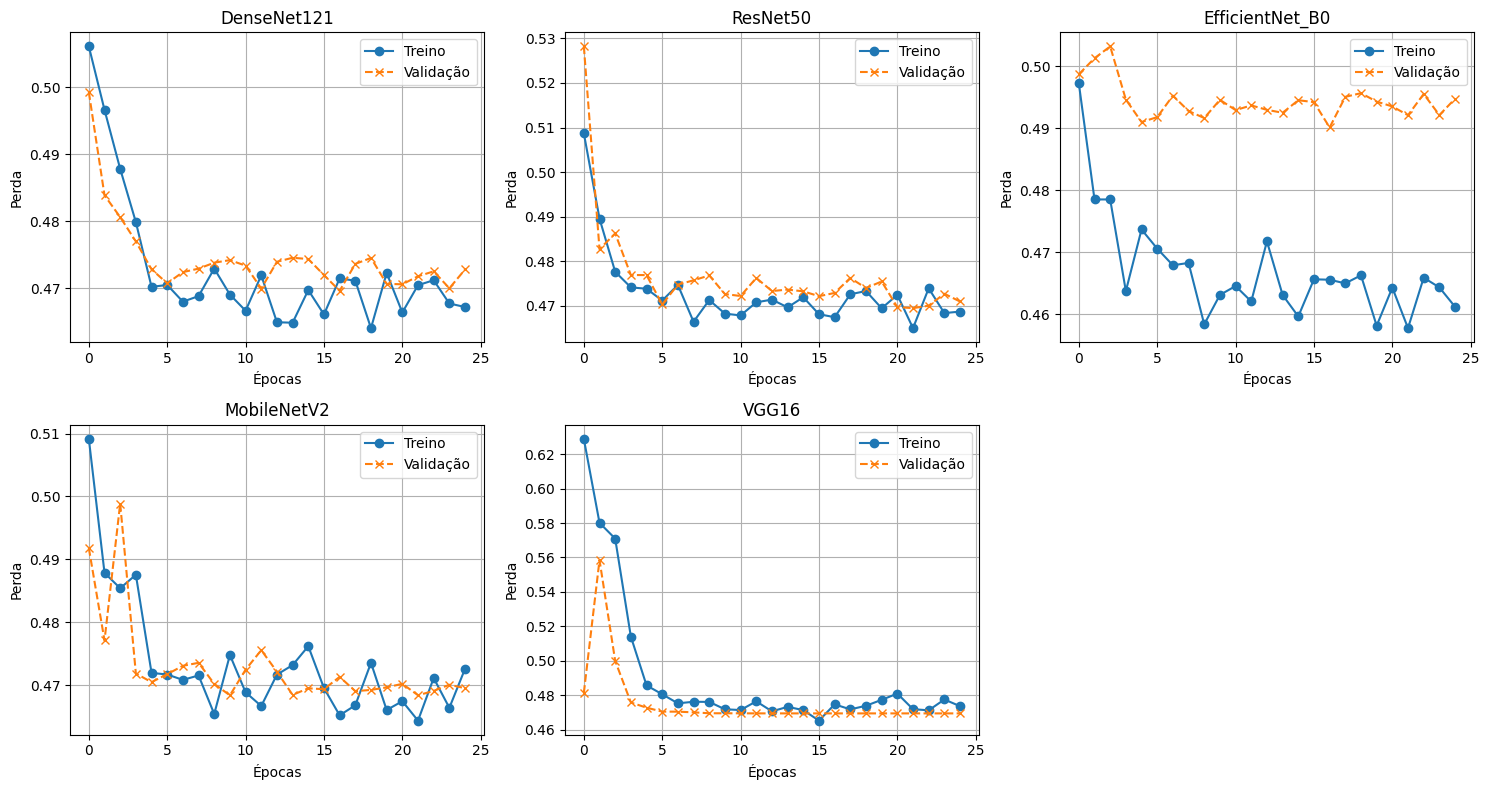

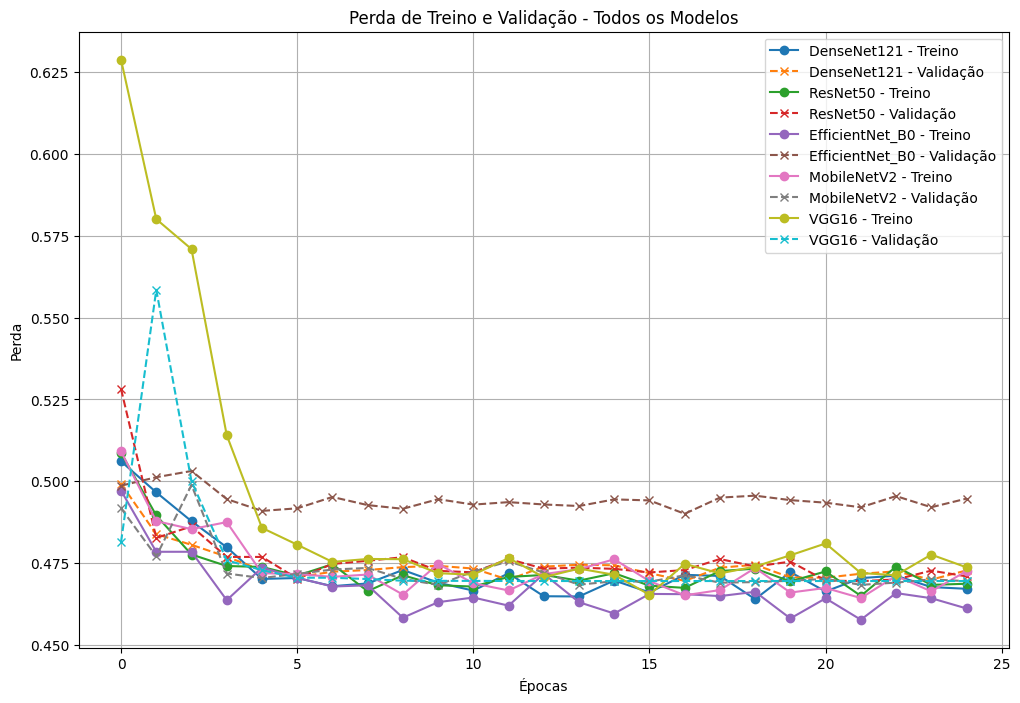

In [38]:
#16 Plotar as Perdas de Treino e Validação com Subplots

import matplotlib.pyplot as plt

def plot_losses(results, cols=3):
    """
    Plota as perdas de treino e validação para cada modelo em subplots organizados.
    Também exibe um gráfico consolidado no final.
    
    Args:
        results (dict): Dicionário com as perdas de treino e validação de cada modelo.
        cols (int): Número de colunas para os subplots.
    """
    num_models = len(results)
    rows = (num_models + cols - 1) // cols  # Calcular o número de linhas necessário

    # Criar subplots organizados
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4))
    axes = axes.flatten()  # Flatten para facilitar iteração

    for i, (model_name, metrics) in enumerate(results.items()):
        train_losses = metrics["train_losses"]
        valid_losses = metrics["valid_losses"]

        ax = axes[i]
        ax.plot(train_losses, label='Treino', linestyle='-', marker='o')
        ax.plot(valid_losses, label='Validação', linestyle='--', marker='x')

        # Configurações do subplot
        ax.set_title(f'{model_name}')
        ax.set_xlabel('Épocas')
        ax.set_ylabel('Perda')
        ax.legend()
        ax.grid(True)

    # Remover subplots vazios se houver menos modelos que subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    # Ajustar layout
    plt.tight_layout()
    plt.show()

    # Gráfico consolidado com todos os modelos
    plt.figure(figsize=(12, 8))
    for model_name, metrics in results.items():
        plt.plot(metrics["train_losses"], label=f'{model_name} - Treino', linestyle='-', marker='o')
        plt.plot(metrics["valid_losses"], label=f'{model_name} - Validação', linestyle='--', marker='x')

    # Configurações do gráfico consolidado
    plt.xlabel('Épocas')
    plt.ylabel('Perda')
    plt.title('Perda de Treino e Validação - Todos os Modelos')
    plt.legend()
    plt.grid(True)
    plt.show()

# Chamar a função para plotar as perdas
plot_losses(results)


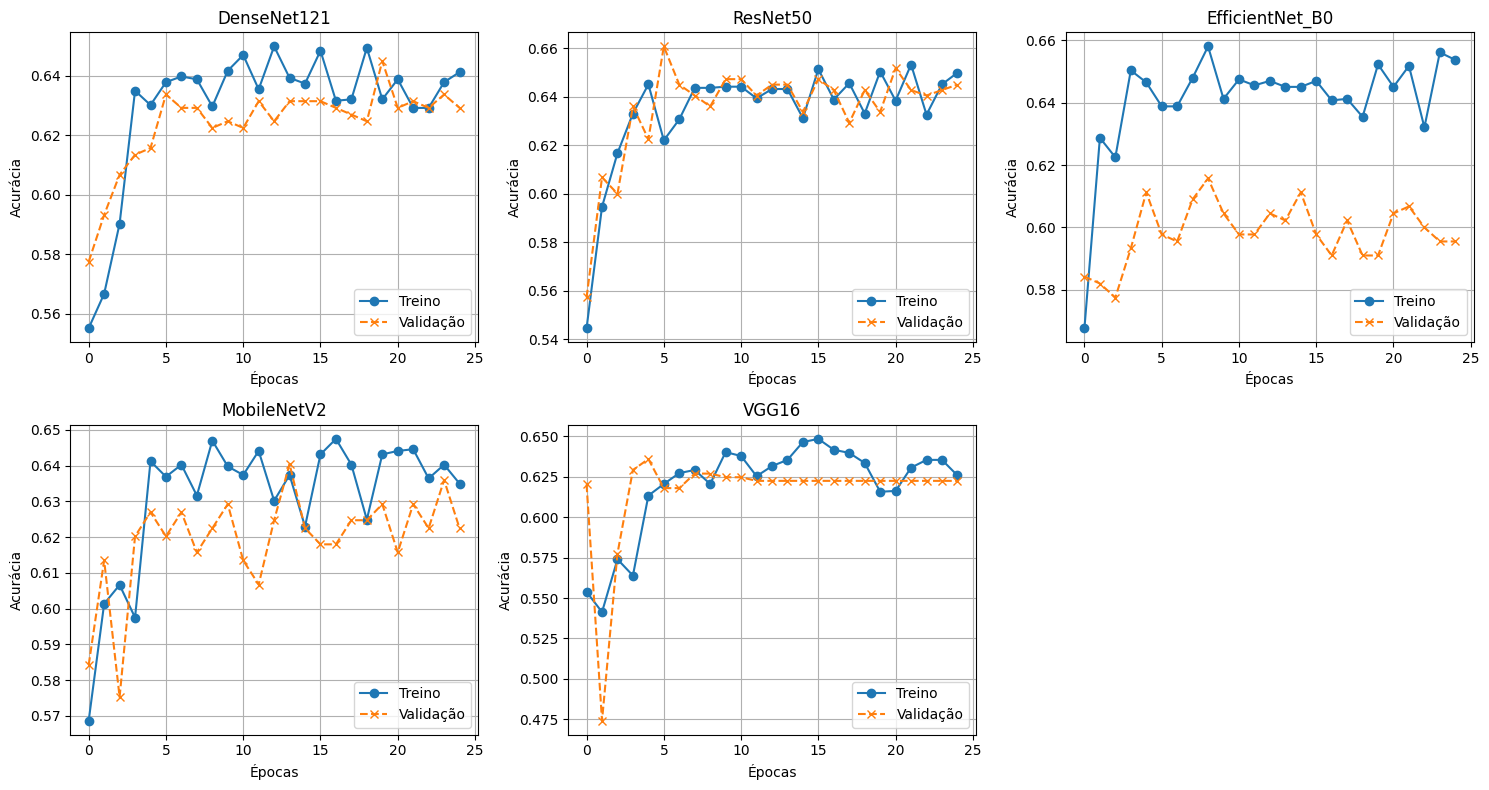

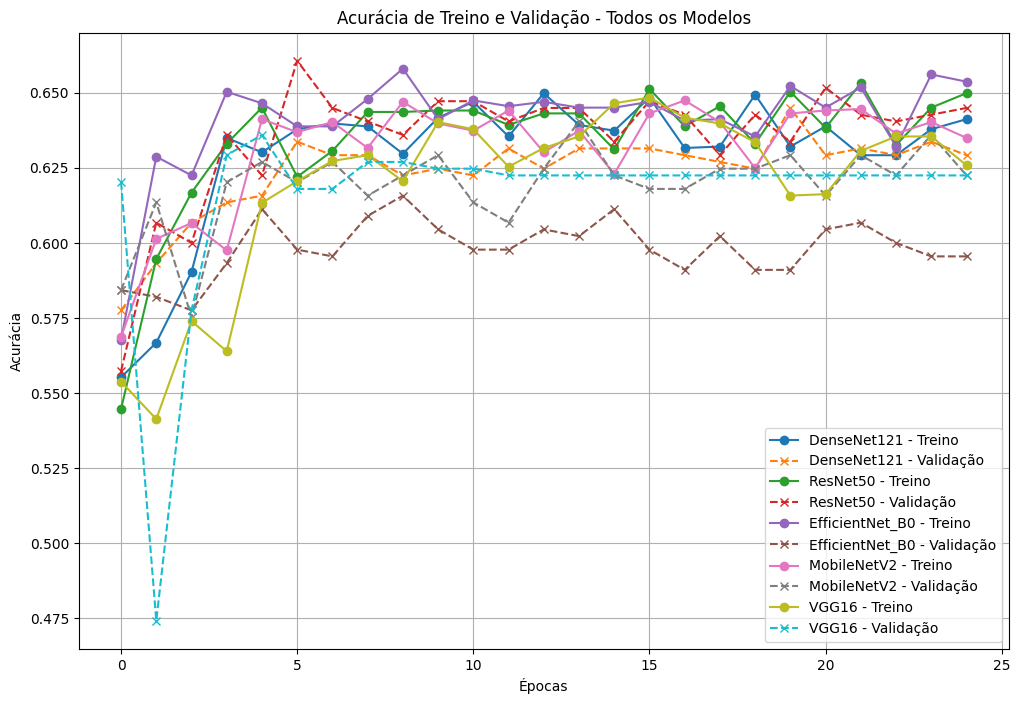

In [40]:
#17 Plotar a Acurácia de Treino e Validação com Subplots

def plot_accuracies(results, cols=3):
    """
    Plota as acurácias de treino e validação para cada modelo em subplots organizados.
    Também exibe um gráfico consolidado no final.
    
    Args:
        results (dict): Dicionário com as acurácias de treino e validação de cada modelo.
        cols (int): Número de colunas para os subplots.
    """
    num_models = len(results)
    rows = (num_models + cols - 1) // cols  # Calcular o número de linhas necessário

    # Criar subplots organizados
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4))
    axes = axes.flatten()  # Flatten para facilitar iteração

    for i, (model_name, metrics) in enumerate(results.items()):
        train_acc = np.array(metrics["train_acc"])  # Acurácia de treino
        valid_acc = np.array(metrics["valid_acc"])  # Acurácia de validação

        ax = axes[i]
        ax.plot(train_acc, label='Treino', linestyle='-', marker='o')
        ax.plot(valid_acc, label='Validação', linestyle='--', marker='x')

        # Configurações do subplot
        ax.set_title(f'{model_name}')
        ax.set_xlabel('Épocas')
        ax.set_ylabel('Acurácia')
        ax.legend()
        ax.grid(True)

    # Remover subplots vazios se houver menos modelos que subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    # Ajustar layout
    plt.tight_layout()
    plt.show()

    # Gráfico consolidado com todos os modelos
    plt.figure(figsize=(12, 8))
    for model_name, metrics in results.items():
        train_acc = np.array(metrics["train_acc"])
        valid_acc = np.array(metrics["valid_acc"])

        plt.plot(train_acc, label=f'{model_name} - Treino', linestyle='-', marker='o')
        plt.plot(valid_acc, label=f'{model_name} - Validação', linestyle='--', marker='x')

    # Configurações do gráfico consolidado
    plt.xlabel('Épocas')
    plt.ylabel('Acurácia')
    plt.title('Acurácia de Treino e Validação - Todos os Modelos')
    plt.legend()
    plt.grid(True)
    plt.show()

# Chamar a função para plotar as acurácias
plot_accuracies(results)




In [29]:
#18 Avaliação no Conjunto de Teste

from sklearn.metrics import classification_report

def evaluate_on_test(models_config):
    """
    Avalia cada modelo no conjunto de teste e armazena os valores reais e previstos.

    Args:
        models_config (dict): Dicionário contendo os modelos e suas configurações.
    """
    for model_name, config in models_config.items():
        print(f"\nAvaliação no conjunto de teste para o modelo: {model_name}")

        # Obter o modelo e a função de perda
        model = config["model"]
        loss_fn = config["loss_fn"]

        # Colocar o modelo em modo de avaliação
        model.eval()

        y_true = []
        y_hat = []

        test_size = 0
        test_loss = 0.0
        test_accuracy = 0.0

        with torch.no_grad():
            for images, labels in test_dataloader:
                images, labels = images.to(device), labels.to(device)

                # Ajustar os canais para modelos como DenseNet e ResNet
                if images.shape[1] == 1:  # Escala de cinza
                    images = images.repeat(1, 3, 1, 1)

                # Forward
                outputs = model(images)
                loss = loss_fn(outputs, F.one_hot(labels, 2).float())

                # Calcular acurácia
                _, preds = torch.max(outputs, 1)
                test_accuracy += torch.sum(preds == labels.data).item()

                # Salvar valores verdadeiros e previstos
                y_true.extend(labels.cpu().numpy().tolist())
                y_hat.extend(preds.cpu().numpy().tolist())

                # Somar a perda e o tamanho
                test_loss += loss.item() * images.size(0)
                test_size += images.size(0)

        # Calcular estatísticas finais do teste
        test_loss = test_loss / test_size
        test_accuracy = test_accuracy / test_size

        # Armazenar valores no dicionário de configurações
        models_config[model_name]["y_true"] = y_true
        models_config[model_name]["y_hat"] = y_hat

        # Exibir resultados
        print(f"Test Loss: {test_loss:.3f}, Test Accuracy: {test_accuracy:.3f}")

        # Relatório de classificação detalhado
        print("\nRelatório de Classificação:")
        print(classification_report(y_true, y_hat, target_names=["Normal", "Abnormal"]))


# Avaliar todos os modelos no conjunto de teste
evaluate_on_test(configurations)



Avaliação no conjunto de teste para o modelo: DenseNet121
Test Loss: 0.467, Test Accuracy: 0.641

Relatório de Classificação:
              precision    recall  f1-score   support

      Normal       0.63      0.85      0.73       250
    Abnormal       0.67      0.38      0.48       199

    accuracy                           0.64       449
   macro avg       0.65      0.61      0.60       449
weighted avg       0.65      0.64      0.62       449


Avaliação no conjunto de teste para o modelo: ResNet50
Test Loss: 0.475, Test Accuracy: 0.615

Relatório de Classificação:
              precision    recall  f1-score   support

      Normal       0.60      0.89      0.72       250
    Abnormal       0.66      0.27      0.38       199

    accuracy                           0.61       449
   macro avg       0.63      0.58      0.55       449
weighted avg       0.63      0.61      0.57       449


Avaliação no conjunto de teste para o modelo: EfficientNet_B0
Test Loss: 0.473, Test Accuracy:

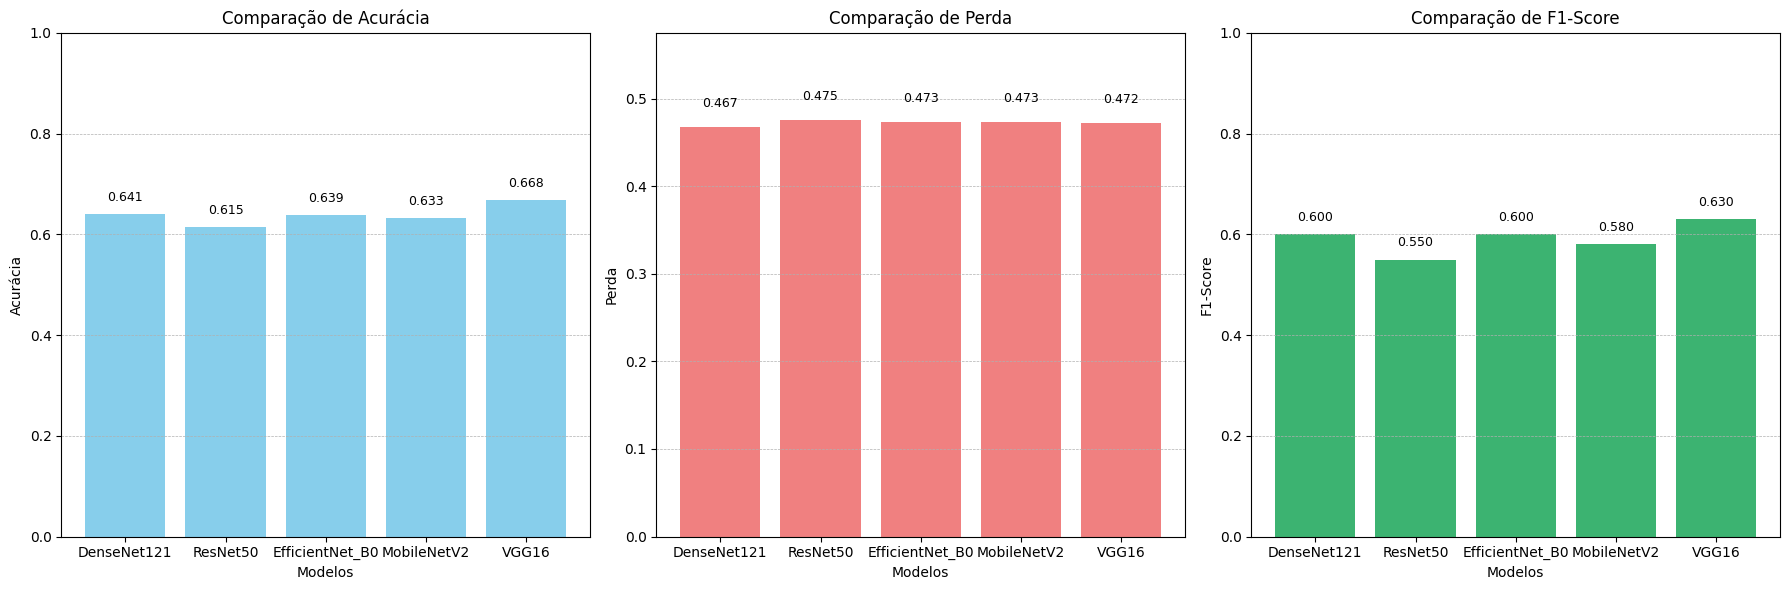

In [39]:
import matplotlib.pyplot as plt
import numpy as np

# Dados explícitos fornecidos
models = ["DenseNet121", "ResNet50", "EfficientNet_B0", "MobileNetV2", "VGG16"]
accuracies = [0.641, 0.615, 0.639, 0.633, 0.668]
losses = [0.467, 0.475, 0.473, 0.473, 0.472]
f1_scores = [0.60, 0.55, 0.60, 0.58, 0.63]

# Função para adicionar valores no topo das barras
def add_values_on_top(ax, values):
    for i, value in enumerate(values):
        ax.text(i, value + 0.02, f"{value:.3f}", ha="center", va="bottom", fontsize=9)

# Criar subplots para organizar os gráficos lado a lado
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Gráfico de Acurácia
axes[0].bar(models, accuracies, color="skyblue", label="Acurácia")
axes[0].set_xlabel("Modelos")
axes[0].set_ylabel("Acurácia")
axes[0].set_title("Comparação de Acurácia")
axes[0].set_ylim(0, 1)
axes[0].grid(axis="y", linestyle="--", linewidth=0.5)
add_values_on_top(axes[0], accuracies)

# Gráfico de Perda
axes[1].bar(models, losses, color="lightcoral", label="Perda")
axes[1].set_xlabel("Modelos")
axes[1].set_ylabel("Perda")
axes[1].set_title("Comparação de Perda")
axes[1].set_ylim(0, max(losses) + 0.1)
axes[1].grid(axis="y", linestyle="--", linewidth=0.5)
add_values_on_top(axes[1], losses)

# Gráfico de F1-Score
axes[2].bar(models, f1_scores, color="mediumseagreen", label="F1-Score")
axes[2].set_xlabel("Modelos")
axes[2].set_ylabel("F1-Score")
axes[2].set_title("Comparação de F1-Score")
axes[2].set_ylim(0, 1)
axes[2].grid(axis="y", linestyle="--", linewidth=0.5)
add_values_on_top(axes[2], f1_scores)

# Ajustar layout para melhor visualização
plt.tight_layout()
plt.show()


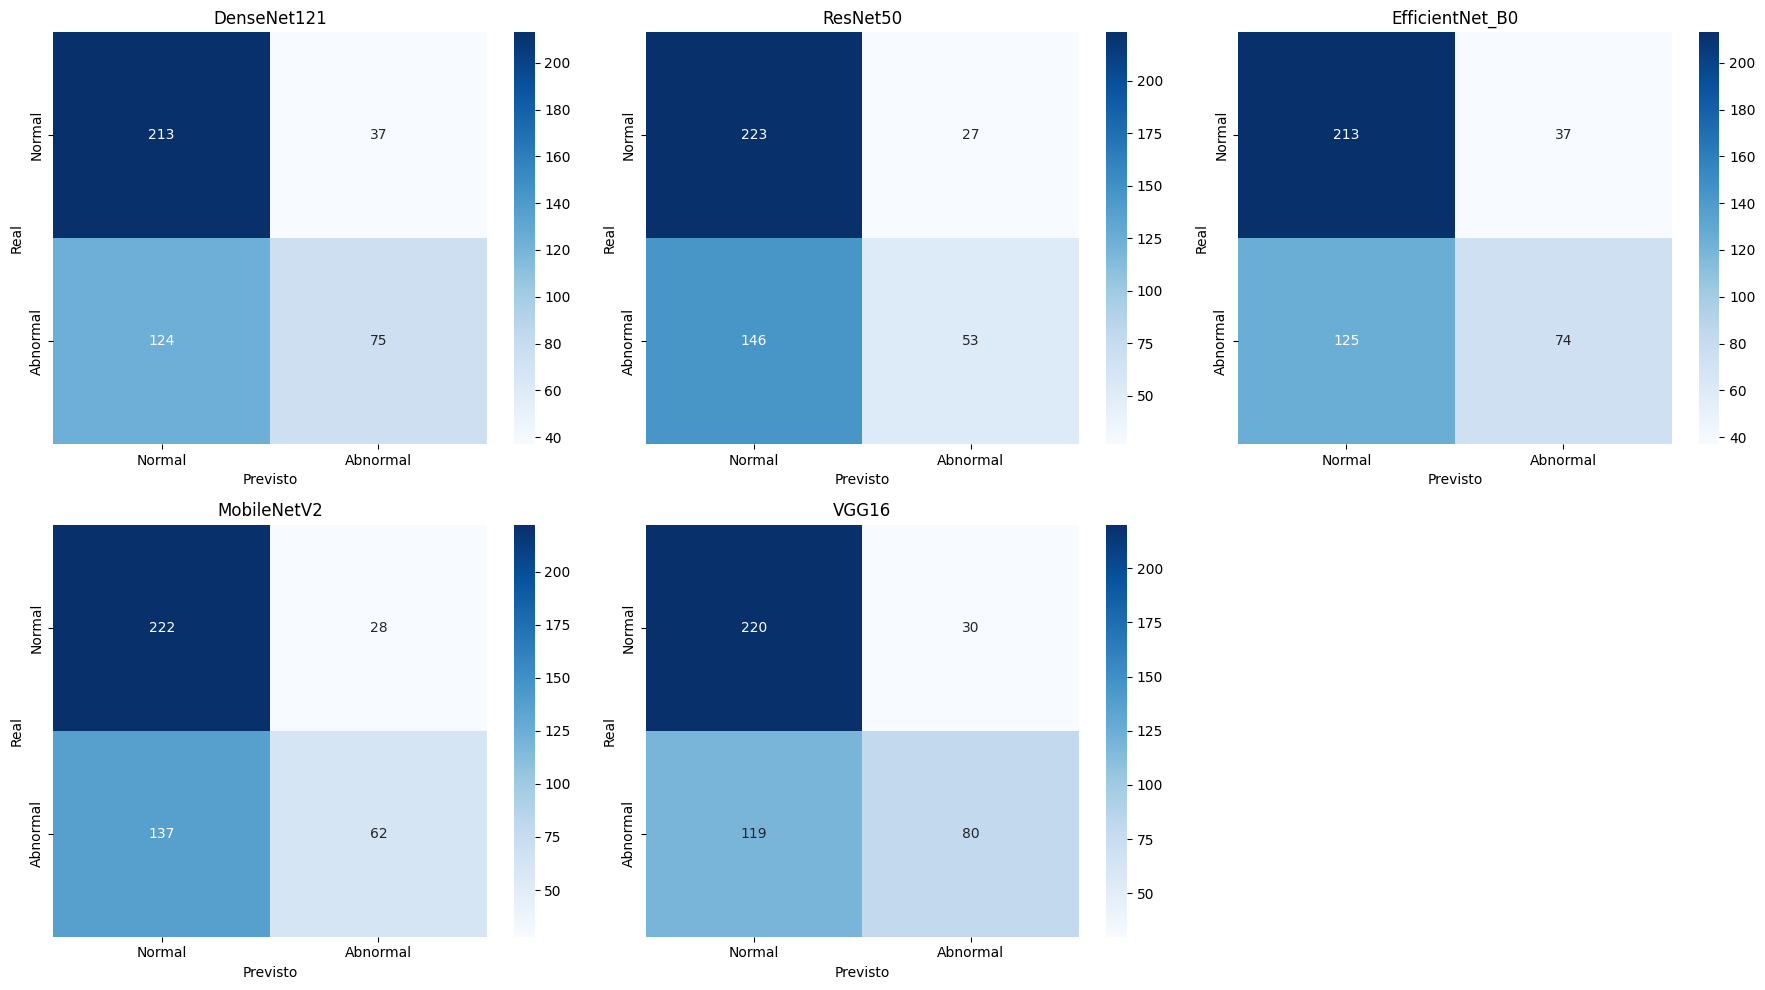

In [32]:
#21 Gerar Matrizes de Confusão em Subplots
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrices(models_config, cols=3):
    """
    Gera matrizes de confusão para todos os modelos em subplots organizados.
    
    Args:
        models_config (dict): Dicionário com as configurações dos modelos e os valores previstos e reais.
        cols (int): Número de colunas para os subplots.
    """
    num_models = len(models_config)
    rows = (num_models + cols - 1) // cols  # Calcular o número de linhas necessário
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 6, rows * 5))
    axes = axes.flatten()  # Flatten para iteração fácil

    for i, (model_name, config) in enumerate(models_config.items()):
        y_true = config.get("y_true", [])
        y_hat = config.get("y_hat", [])

        if not y_true or not y_hat:
            print(f"Erro: Valores verdadeiros e previstos ausentes para o modelo {model_name}.")
            continue

        # Gerar matriz de confusão
        conf_matrix = confusion_matrix(y_true, y_hat)

        # Plotar no subplot
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                    xticklabels=['Normal', 'Abnormal'], yticklabels=['Normal', 'Abnormal'],
                    ax=axes[i])
        axes[i].set_title(f'{model_name}')
        axes[i].set_xlabel('Previsto')
        axes[i].set_ylabel('Real')

    # Remover eixos vazios se houver menos modelos que subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    # Ajustar layout
    plt.tight_layout()
    plt.show()

# Gerar matrizes de confusão organizadas
plot_confusion_matrices(configurations)


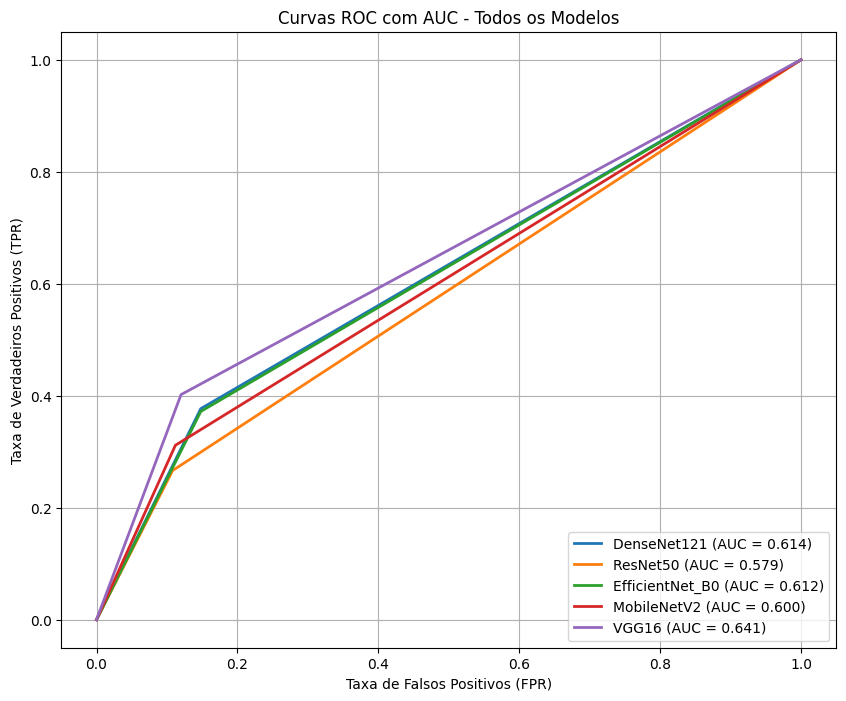

In [33]:
#23 Plotar Curvas ROC com AUC para Todos os Modelos
from sklearn.metrics import roc_curve, roc_auc_score

def plot_roc_curves(models_config):
    """
    Gera e exibe curvas ROC com AUC para todos os modelos.
    
    Args:
        models_config (dict): Dicionário com as configurações dos modelos e os valores previstos e reais.
    """
    plt.figure(figsize=(10, 8))

    for model_name, config in models_config.items():
        y_true = config.get("y_true", [])
        y_hat = config.get("y_hat", [])

        if not y_true or not y_hat:
            print(f"Erro: Valores verdadeiros e previstos ausentes para o modelo {model_name}.")
            continue

        # Calcular os valores para a curva ROC
        fpr, tpr, _ = roc_curve(y_true, y_hat)
        auc = roc_auc_score(y_true, y_hat)

        # Adicionar ao gráfico
        plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc:.3f})', linewidth=2)

    # Configurações do gráfico
    plt.title('Curvas ROC com AUC - Todos os Modelos')
    plt.xlabel('Taxa de Falsos Positivos (FPR)')
    plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

plot_roc_curves(configurations)


In [35]:
#24 Salvando e Carregando Todos os Modelos (Corrigido)
from pathlib import Path
import datetime

def save_and_load_models(models_config, save_dir="/home/thalles.fontainha/modelos"):
    """
    Salva e carrega todos os modelos treinados no diretório especificado.
    
    Args:
        models_config (dict): Dicionário com as configurações dos modelos.
        save_dir (str): Caminho para o diretório onde os modelos serão salvos.
    """
    save_path = Path(save_dir)
    save_path.mkdir(parents=True, exist_ok=True)

    for model_name, config in models_config.items():
        model = config["model"]

        # Definir o nome e o caminho do arquivo
        model_file = f"{model_name}_treinado_{datetime.datetime.now():%Y-%m-%d_%H-%M-%S}.pth"
        model_save_path = save_path / model_file

        # Salvar o modelo
        print(f"Salvando o modelo {model_name} em: {model_save_path}")
        torch.save(model.state_dict(), model_save_path)

        # Carregar o modelo salvo com segurança
        print(f"Carregando o modelo {model_name} de: {model_save_path}")
        state_dict = torch.load(model_save_path, weights_only=True)  # Especificar weights_only=True
        model.load_state_dict(state_dict)
        model = model.to(device)  # Garantir que o modelo esteja no dispositivo correto

        # Confirmar o carregamento
        print(f"Modelo {model_name} carregado com sucesso!")

save_and_load_models(configurations)


Salvando o modelo DenseNet121 em: /home/thalles.fontainha/modelos/DenseNet121_treinado_2025-01-21_12-51-34.pth
Carregando o modelo DenseNet121 de: /home/thalles.fontainha/modelos/DenseNet121_treinado_2025-01-21_12-51-34.pth
Modelo DenseNet121 carregado com sucesso!
Salvando o modelo ResNet50 em: /home/thalles.fontainha/modelos/ResNet50_treinado_2025-01-21_12-51-34.pth
Carregando o modelo ResNet50 de: /home/thalles.fontainha/modelos/ResNet50_treinado_2025-01-21_12-51-34.pth
Modelo ResNet50 carregado com sucesso!
Salvando o modelo EfficientNet_B0 em: /home/thalles.fontainha/modelos/EfficientNet_B0_treinado_2025-01-21_12-51-34.pth
Carregando o modelo EfficientNet_B0 de: /home/thalles.fontainha/modelos/EfficientNet_B0_treinado_2025-01-21_12-51-34.pth
Modelo EfficientNet_B0 carregado com sucesso!
Salvando o modelo MobileNetV2 em: /home/thalles.fontainha/modelos/MobileNetV2_treinado_2025-01-21_12-51-34.pth
Carregando o modelo MobileNetV2 de: /home/thalles.fontainha/modelos/MobileNetV2_treina